# List of Assignments 3 – time series shapelets / recommendation systems

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import entropy
from time import time
from sklearn.metrics import confusion_matrix

from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

## Assignment 1. (5 points)
Recall the general brute-force algorithm for finding characteristic time series shapelets described in our lecture or its detailed version described in [1].

    a) Write a function for finding characteristic time series shapelets for a given dataset of time series.

    b) Construct a few simple example datasets and verify the results of your function with some illustrations of the shapelets discovered and their location in some selected time series from the dataset.

    c) Evaluate computation time of your function. Try to optimize it with your own improvements or the improvements proposed in [1].

[1] L. Ye, E. Keogh, "Time Series Shapelets: A New Primitive for Data Mining". International Conference on Knowledge Discovery and Data Mining, 2009, pp.947-956.

### a) 
Write a function for finding characteristic time series shapelets for a given dataset of time series.

In [2]:
sin = [np.sin(x) for x in np.arange(0, np.pi + 0.00001, np.pi / 9)]
triangular = [0 for _ in range(10)]
triangular[5] = 1
triangular[4] = triangular[6] = 0.5
square = [1 for _ in range(10)]
square[0] = square[-1] = 0

training_data = np.random.rand(9, 30) / 20
shapes = [sin, triangular, square]
for i in range(9):
    offset = np.random.randint(1, 20)
    training_data[i, offset:offset + 10] += shapes[i // 3]

training_labels = [i // 3 for i in range(9)]

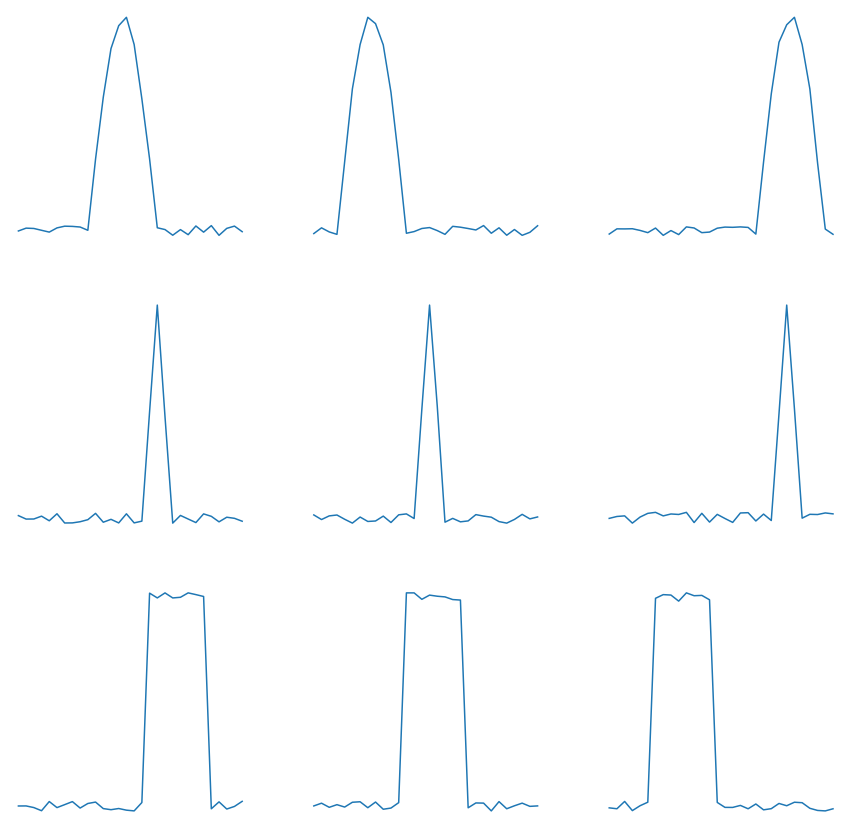

In [3]:
f, axs = plt.subplots(3, 3, figsize=(15, 15))
for i in range(9):
    axs[i // 3, i % 3].axis('off')
    axs[i // 3, i % 3].plot(training_data[i])

In [52]:
def subsequence_distance(time_series, shapelet, return_offset=False):
    time_series_length = len(time_series)
    shapelet_length = len(shapelet)

    time_series = np.array(time_series)
    shapelet = np.array(shapelet)

    min_distance = np.inf
    best_offset = -1
    for offset in range(time_series_length - shapelet_length + 1):
        dist = np.sum(
            (time_series[offset:offset + shapelet_length] - shapelet)**2)
        if dist < min_distance:
            min_distance = dist
            best_offset = offset

    if return_offset:
        return min_distance, best_offset
    return min_distance

In [5]:
# source - https://stackoverflow.com/questions/46752650/information-gain-calculation-with-scikit-learn
def information_gain(members, split):
    '''
    Measures the reduction in entropy after the split  
    :param v: Pandas Series of the members
    :param split:
    :return:
    '''
    entropy_before = entropy(members.value_counts(normalize=True))
    split.name = 'split'
    members.name = 'members'
    grouped_distrib = members.groupby(split) \
                        .value_counts(normalize=True) \
                        .reset_index(name='count') \
                        .pivot_table(index='split', columns='members', values='count').fillna(0)
    entropy_after = entropy(grouped_distrib, axis=1)
    entropy_after *= split.value_counts(sort=False, normalize=True)
    return entropy_before - entropy_after.sum()

In [6]:
def extract_candidates(data, min_length, max_length):
    candidates = []

    for length_of_shapelet in range(min_length, max_length + 1):
        for time_serie in data:
            length_of_time_serie = len(time_serie)
            for offset in range(length_of_time_serie - length_of_shapelet + 1):
                candidates.append(time_serie[offset:offset +
                                             length_of_shapelet])

    return np.array(candidates)

In [7]:
def _get_IG_for_shapelet(data, labels, shapelet, return_times=False):
    labels_series = pd.Series(labels)
    t = time()
    distances = np.array(
        [subsequence_distance(sample, shapelet) for sample in training_data])
    distnaces_time = time() - t
    t = time()

    best_IG = 0
    for d in distances:
        split = pd.Series(distances < d)
        IG = information_gain(labels_series, split)
        best_IG = max(best_IG, IG)
    IG_time = time() - t

    if return_times:
        return best_IG, distnaces_time, IG_time
    return best_IG

In [8]:
def my_entropy(labels):
    value, counts = np.unique(labels, return_counts=True)
    return entropy(counts)

In [9]:
def get_IG_for_shapelet(data, labels, shapelet, return_times=False):
    t = time()
    distances = np.array(
        [subsequence_distance(sample, shapelet) for sample in data])
    labels = np.array(labels)
    distnaces_time = time() - t
    t = time()

    best_IG = 0
    entropy_before = my_entropy(training_labels)

    for d in distances:
        split = distances < d
        true_ratio = np.mean(split)
        false_ratio = 1 - true_ratio
        true_labels = labels[split]
        false_labels = labels[~split]

        IG = entropy_before - true_ratio * my_entropy(
            true_labels) - false_ratio * my_entropy(false_labels)
        best_IG = max(best_IG, IG)

    IG_time = time() - t

    if return_times:
        return best_IG, distnaces_time, IG_time
    return best_IG

In [10]:
def get_shapelets(data, labels, N, min_length, max_length=None):
    if max_length is None:
        max_length = min_length

    candidates = extract_candidates(data, min_length, max_length)
    candidates_scores = np.array([
        get_IG_for_shapelet(data, labels, shapelet) for shapelet in candidates
    ])
    best_candidates = np.argsort(-candidates_scores)[:N]

    return candidates[best_candidates]

In [11]:
discovered_shapelets = get_shapelets(training_data, training_labels, 30, 10, 10)

### b) 
Construct a few simple example datasets and verify the results of your function with some illustrations of the shapelets discovered and their location in some selected time series from the dataset.

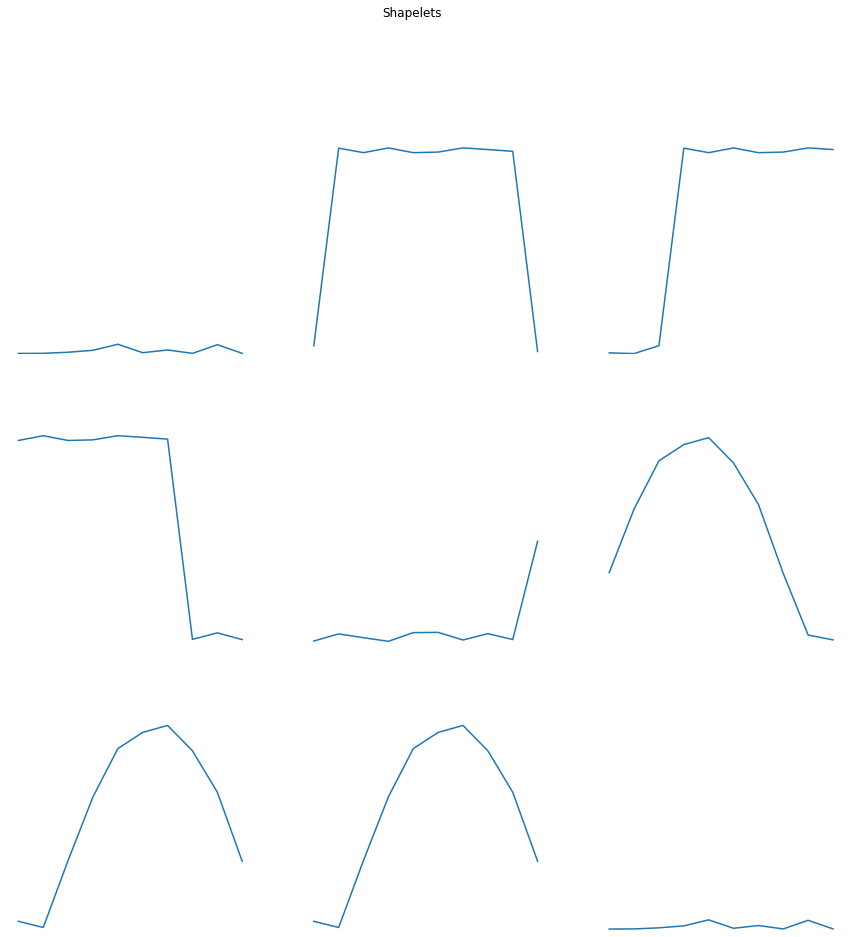

In [12]:
f, axs = plt.subplots(3, 3, figsize=(15, 15))
for i in range(9):
    axs[i // 3, i % 3].axis('off')
    axs[i // 3, i % 3].set_ylim([0, 1.2])
    axs[i // 3, i % 3].plot(discovered_shapelets[np.random.randint(
        0, len(discovered_shapelets))])
f.suptitle("Shapelets")
plt.show()

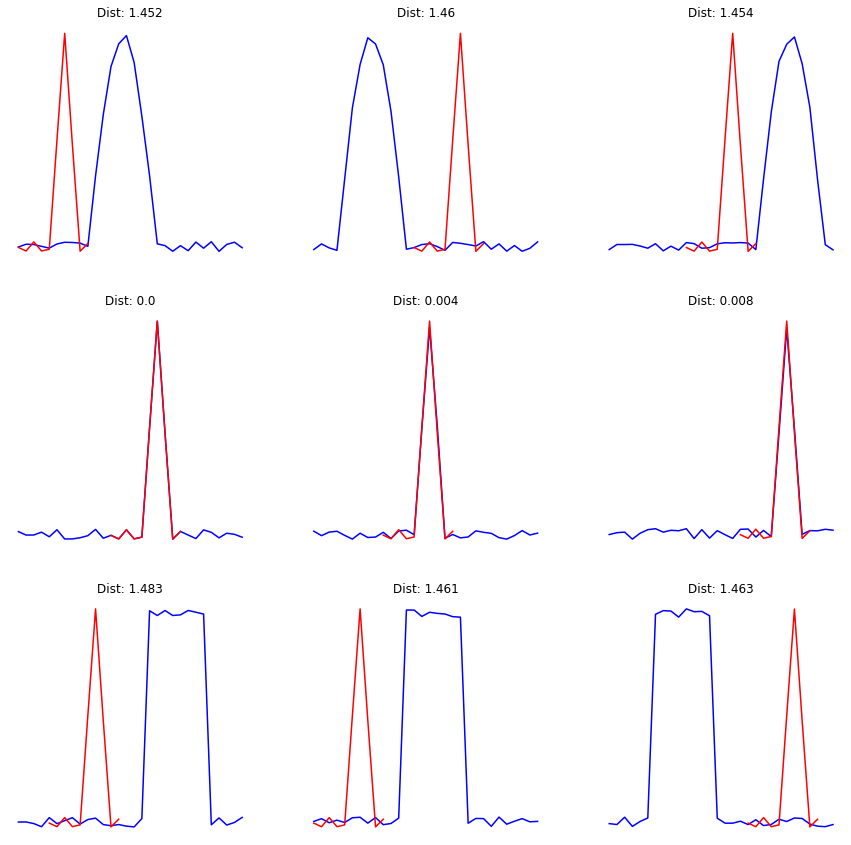

In [14]:
shapelet = discovered_shapelets[np.random.randint(0, len(discovered_shapelets))]

f, axs = plt.subplots(3, 3, figsize=(15, 15))
for i in range(9):
    axs[i // 3, i % 3].axis('off')
    axs[i // 3, i % 3].plot(training_data[i], color='blue')
    dist, offset = subsequence_distance(training_data[i],
                                        shapelet,
                                        return_offset=True)
    axs[i // 3, i % 3].plot([offset + i for i in range(len(shapelet))],
                            shapelet,
                            color='red')
    axs[i // 3, i % 3].set_title(f'Dist: {np.round(dist,3)}')

### c) 
Evaluate computation time of your function. Try to optimize it with your own improvements or the improvements proposed in [1].

In [50]:
def get_shapelets_with_times(data,
                             labels,
                             N,
                             min_length,
                             max_length=None,
                             debug_info=True):
    if max_length is None:
        max_length = min_length

    t = time()
    candidates = extract_candidates(data, min_length, max_length)
    if debug_info:
        print("Time for candidates generating: ", time() - t)

    distnaces_time, IG_time = 0, 0
    candidates_scores = []

    for shapelet in candidates:
        IG, t1, t2 = get_IG_for_shapelet(data, labels, shapelet, True)
        candidates_scores.append(IG)
        distnaces_time += t1
        IG_time += t2

    candidates_scores = np.array(candidates_scores)

    if debug_info:
        print("Time for distance calcuating: ", distnaces_time)
        print("Time for IG measuring: ", IG_time)

    t = time()
    best_candidates = np.argsort(-candidates_scores)[:N]
    if debug_info:
        print("Time for argsorting: ", time() - t)

    return candidates[best_candidates], distnaces_time, IG_time

In [51]:
discovered_shapelets, distnaces_time, IG_time = get_shapelets_with_times(
    training_data, training_labels, 30, 10, 10)

Time for candidates generating:  0.0
Time for distance calcuating:  0.40471482276916504
Time for IG measuring:  0.3662412166595459
Time for argsorting:  0.0


In [153]:
# Using IG from stack overflow
discovered_shapelets = get_shapelets_with_times(training_data, training_labels,
                                                30, 10, 10)

Time for candidates generating:  0.0010075569152832031
Time for distance calcuating:  0.2575960159301758
Time for IG measuring:  21.12588405609131
Time for argsorting:  0.0


In [17]:
def subsequence_distance_early_abandon(time_series,
                                       shapelet,
                                       return_offset=False):
    time_series_length = len(time_series)
    shapelet_length = len(shapelet)

    time_series = np.array(time_series)
    shapelet = np.array(shapelet)

    min_distance = np.inf
    best_offset = -1
    for offset in range(time_series_length - shapelet_length + 1):
        dist = 0
        for i in range(shapelet_length):
            dist += (time_series[offset + i] - shapelet[i])**2
            if dist >= min_distance:
                break
        else:
            min_distance = dist
            best_offset = offset

    if return_offset:
        return min_distance, best_offset
    return min_distance

In [31]:
def get_IG_for_shapelet_early_abandon(data,
                                      labels,
                                      shapelet,
                                      return_times=False):
    t = time()
    distances = np.array([
        subsequence_distance_early_abandon(sample, shapelet) for sample in data
    ])
    labels = np.array(labels)
    distnaces_time = time() - t
    t = time()

    best_IG = 0
    entropy_before = my_entropy(training_labels)

    for d in distances:
        split = distances < d
        true_ratio = np.mean(split)
        false_ratio = 1 - true_ratio
        true_labels = labels[split]
        false_labels = labels[~split]

        IG = entropy_before - true_ratio * my_entropy(
            true_labels) - false_ratio * my_entropy(false_labels)
        best_IG = max(best_IG, IG)

    IG_time = time() - t

    if return_times:
        return best_IG, distnaces_time, IG_time
    return best_IG

In [52]:
def get_shapelets_with_times_early_abandon(data,
                                           labels,
                                           N,
                                           min_length,
                                           max_length=None,
                                           debug_info=True):
    if max_length is None:
        max_length = min_length

    t = time()
    candidates = extract_candidates(data, min_length, max_length)
    if debug_info:
        print("Time for candidates generating: ", time() - t)

    distnaces_time, IG_time = 0, 0
    candidates_scores = []

    for shapelet in candidates:
        IG, t1, t2 = get_IG_for_shapelet_early_abandon(data, labels, shapelet,
                                                       True)
        candidates_scores.append(IG)
        distnaces_time += t1
        IG_time += t2

    candidates_scores = np.array(candidates_scores)

    if debug_info:
        print("Time for distance calcuating: ", distnaces_time)
        print("Time for IG measuring: ", IG_time)

    t = time()
    best_candidates = np.argsort(-candidates_scores)[:N]
    if debug_info:
        print("Time for argsorting: ", time() - t)

    return candidates[best_candidates], distnaces_time, IG_time

In [53]:
discovered_shapelets, distnaces_time, IG_time = get_shapelets_with_times_early_abandon(
    training_data, training_labels, 30, 10, 10)

Time for candidates generating:  0.000995635986328125
Time for distance calcuating:  0.3608834743499756
Time for IG measuring:  0.4451174736022949
Time for argsorting:  0.0


In [55]:
dist_time0 = []
dist_time1 = []
for _ in range(25):
    _, time0, _ = get_shapelets_with_times_early_abandon(
        training_data, training_labels, 30, 10, 10, False)
    _, time1, _ = get_shapelets_with_times(training_data, training_labels, 30,
                                           10, 10, False)
    dist_time0.append(time0)
    dist_time1.append(time1)

dist_time0, dist_time1 = np.mean(np.array(dist_time0)), np.mean(
    np.array(dist_time1))
print('Distance time without abandon: ', dist_time0)
print('Distance time with abandon: ', dist_time1)

Distance time without abandon:  0.31004307746887205
Distance time with abandon:  0.3955214786529541


## Assignment 2. (4 points)
Recall the shapelet learning algorithm described in our lecture or in [2]. Use the algorithm to discover characteristic shapelets in water consumption data from the List of Assignment 2 as well as the Gun Point Dataset and the Arrow Head Dataset. You may use either your own implementation or the implementation available in the pyts [3] package. Try to illustrate the results - present the shapelets discovered and their location in some selected time series from the dataset.

[2] J. Grabocka, N. Schilling, M. Wistuba, L. Schmidt-Thieme, "Learning time-series shapelets". International Conference on Knowledge Discovery and Data Mining, 2014, pp.392-401.

[3] J. Faouzi, H. Janati, "pyts: A python package for time series classification". Journal of Machine Learning Research, 21(46), 2020, pp.1-6.

![](https://i.imgur.com/DXw1b1g.png)
![](https://i.imgur.com/NhSMdwm.png)
![](https://i.imgur.com/BpG9t5P.png)
![](https://i.imgur.com/ffT2Hd7.png)

In [12]:
import pyts
from pyts.classification import LearningShapelets

In [104]:
def plot_shapelets(clf):
    n = clf.shapelets_.shape[1]
    f, axs = plt.subplots(3, 3, figsize=(15, 15))
    for i in range(9):
        axs[i // 3, i % 3].axis('off')
        idx = np.random.randint(0, n)
        shapelet = clf.shapelets_[0][idx]
        axs[i // 3, i % 3].plot(shapelet)
        axs[i // 3, i % 3].set_title(f'Weight: {np.round(clf.coef_[0][idx],3)}')

In [94]:
def visualize_shapelets(clf, X_train, y_train):
    n = len(X_train)
    f, axs = plt.subplots(3, 3, figsize=(15, 15))

    shapelet = clf.shapelets_[0][np.random.randint(0, clf.shapelets_.shape[1])]
    for i in range(9):
        axs[i // 3, i % 3].axis('off')
        idx = np.random.randint(0, n)
        time_serie = X_train[idx]
        axs[i // 3, i % 3].plot(time_serie)

        dist, offset = subsequence_distance(time_serie,
                                            shapelet,
                                            return_offset=True)
        axs[i // 3, i % 3].plot([offset + i for i in range(len(shapelet))],
                                shapelet,
                                color='red')

        axs[i // 3, i % 3].set_title(f'Label: {y_train[idx]}')

### Water Consumption Dataset

In [99]:
df = pd.read_csv('water_consumption_profiles.csv')
df['date'] = df['date'].map(lambda x: pd.to_datetime(x, format='%Y-%m-%d'))
df = df.set_index('date')
df_ = df.groupby([df.index.month, df.index.weekday]).mean()
X = df_.values
y = df_.reset_index([1])['date'].map(lambda x: 0 if x < 5 else 1).values
N = len(y)
shuffled_indices_ = np.random.permutation(N)
test_indices = shuffled_indices_[int(0.65 * N):].copy()
train_indices = shuffled_indices_[:int(0.65 * N)].copy()

X_train, y_train = X[train_indices, :], y[train_indices]
X_test, y_test = X[test_indices, :], y[test_indices]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(54, 144) (54,)
(30, 144) (30,)


In [101]:
clf = LearningShapelets(n_shapelets_per_size=0.2)

In [102]:
clf.fit(X_train, y_train)

c:\python39\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=[1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 0 0 1 0 1 1 0 1 1 0 1 1 0 0
 0 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
c:\python39\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


LearningShapelets()

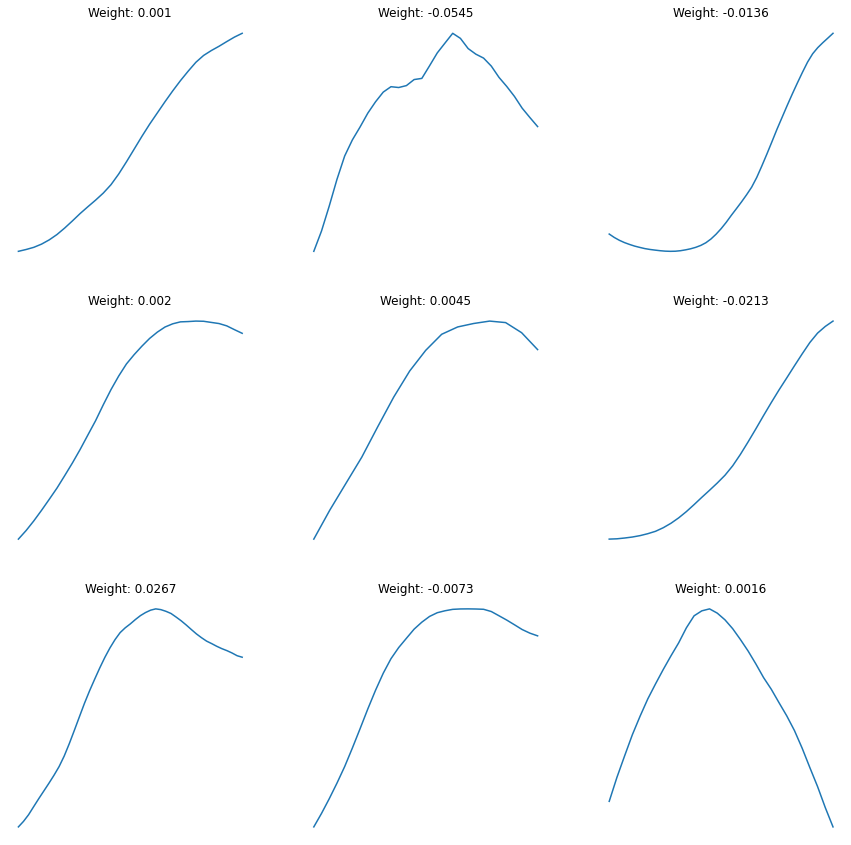

In [103]:
plot_shapelets(clf)

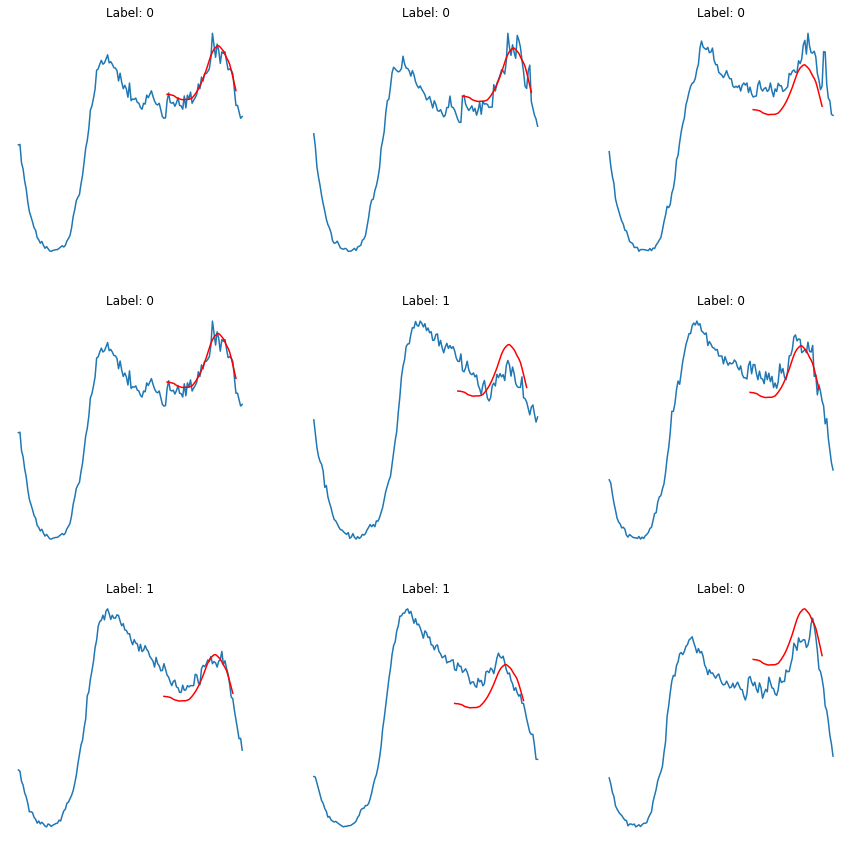

In [105]:
visualize_shapelets(clf, X_train, y_train)

In [107]:
pred_test = clf.predict(X_test)

In [108]:
confusion_matrix(y_test, pred_test)

array([[24,  0],
       [ 0,  6]], dtype=int64)

In [109]:
np.mean(y_test == pred_test)

1.0

### Gun Point Datase

In [6]:
from pyts.datasets import load_gunpoint

In [7]:
X_train, X_test, y_train, y_test = load_gunpoint(return_X_y=True)

In [82]:
clf = LearningShapelets(n_shapelets_per_size=0.2)

In [83]:
clf.fit(X_train, y_train)

c:\python39\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[1 2], y=[2 2 1 1 2 2 2 2 2 1 1 1 1 1 2 1 2 2 1 2 1 1 1 2 1 2 1 1 2 1 1 2 2 1 2 1 2
 2 2 2 2 1 1 1 2 2 1 2 1 2] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
c:\python39\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


LearningShapelets()

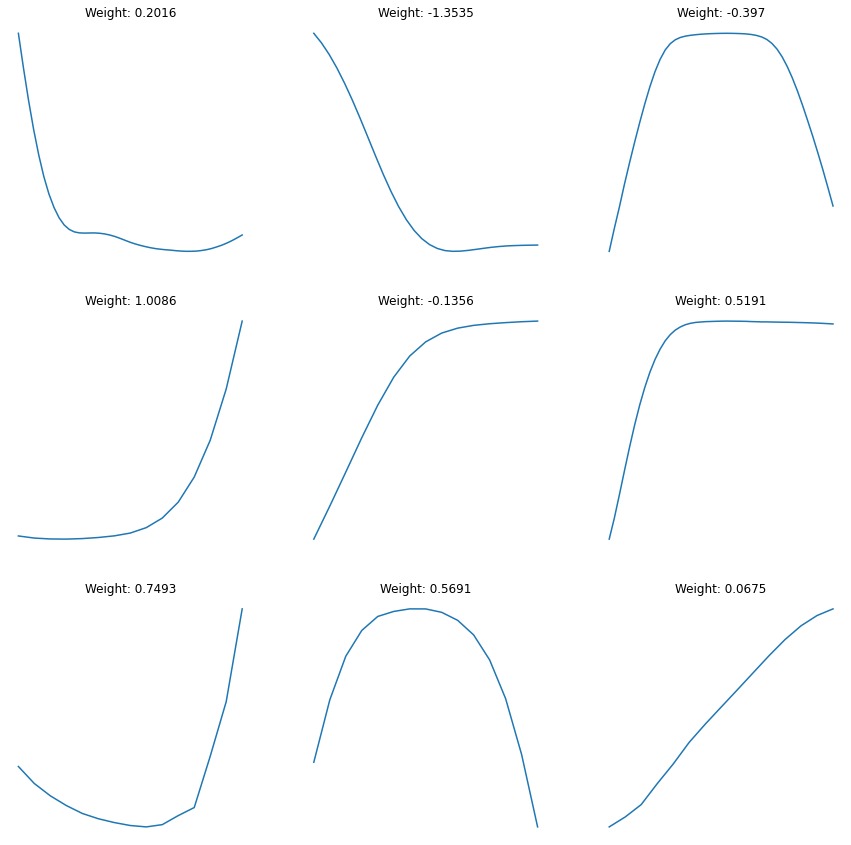

In [84]:
plot_shapelets(clf)

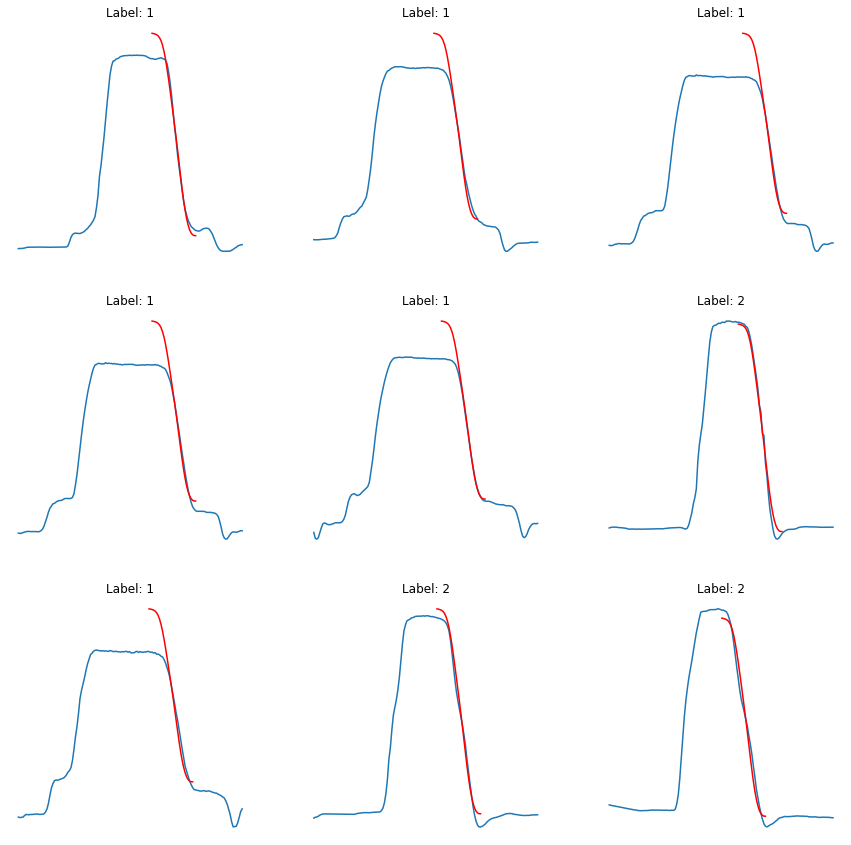

In [89]:
visualize_shapelets(clf, X_train, y_train)

In [90]:
pred_test = clf.predict(X_test)

In [91]:
confusion_matrix(y_test, pred_test)

array([[56, 20],
       [10, 64]], dtype=int64)

In [92]:
np.mean(y_test == pred_test)

0.8

### Arrow Head Dataset

In [110]:
df = pd.read_csv('ArrowHead_TRAIN.txt', delimiter="\t", header=None)
X_train = np.array([
    list(
        map(np.float64,
            filter(lambda e: e, df.loc[i][0].split(':')[0].split(','))))
    for i in df.index
])
y_train = np.array([int(df.loc[i][0].split(':')[-1]) for i in df.index])

In [113]:
df = pd.read_csv('ArrowHead_TEST.txt', delimiter="\t", header=None)
X_test = np.array([
    list(
        map(np.float64,
            filter(lambda e: e, df.loc[i][0].split(':')[0].split(','))))
    for i in df.index
])
y_test = np.array([int(df.loc[i][0].split(':')[-1]) for i in df.index])

In [114]:
clf = LearningShapelets(n_shapelets_per_size=0.2)

In [115]:
clf.fit(X_train, y_train)

c:\python39\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2], y=[0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
c:\python39\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


LearningShapelets()

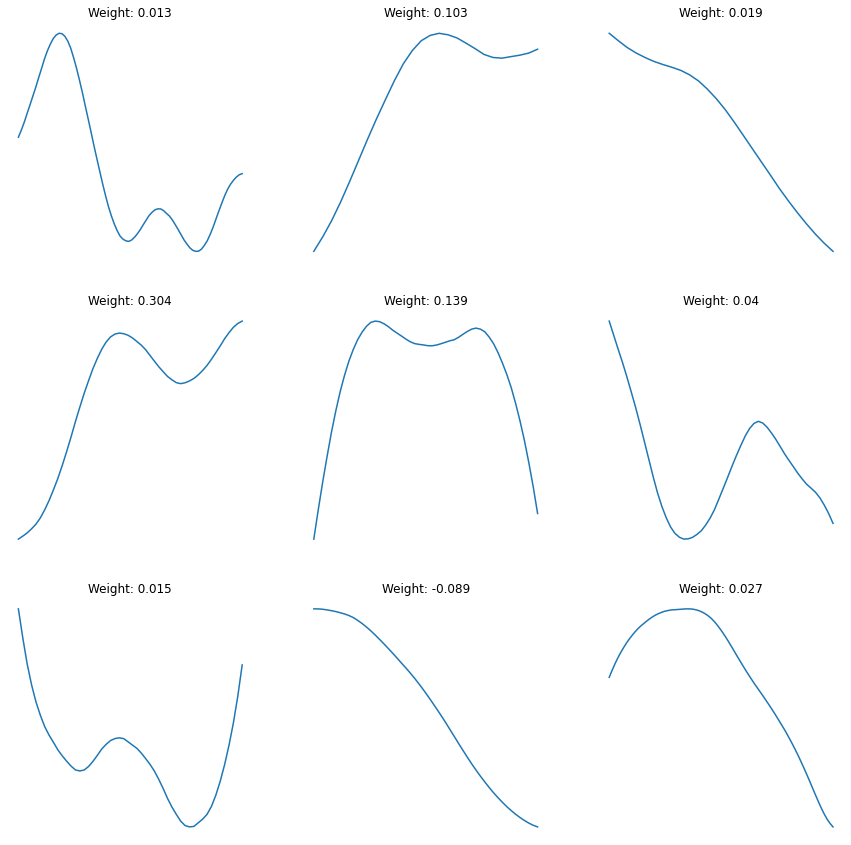

In [116]:
plot_shapelets(clf)

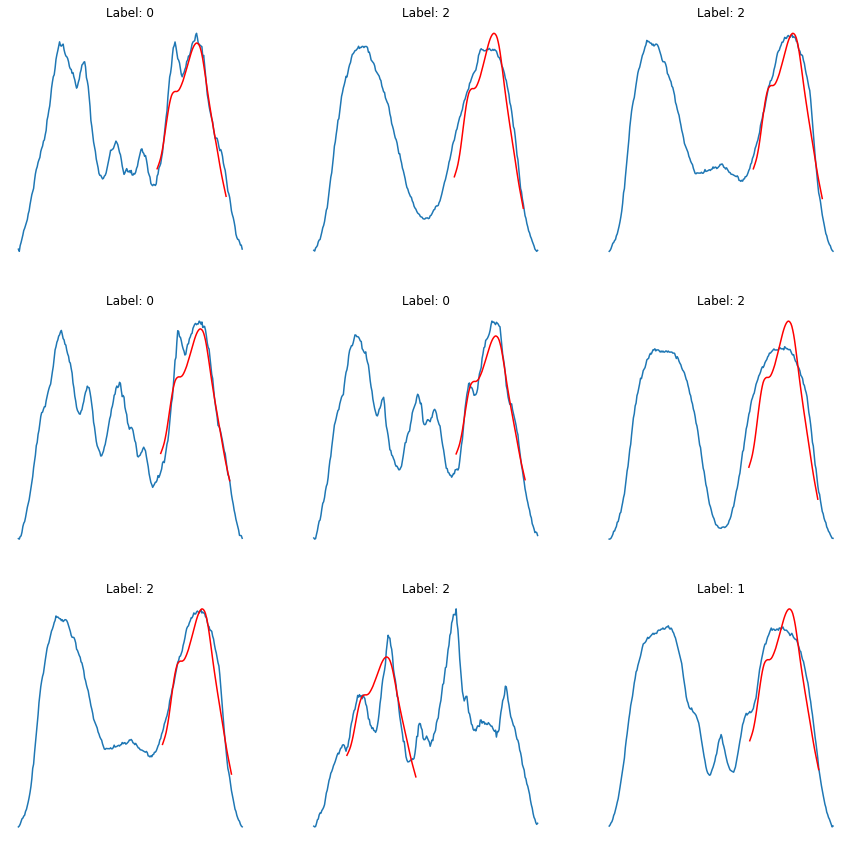

In [117]:
visualize_shapelets(clf, X_train, y_train)

In [118]:
pred_test = clf.predict(X_test)

In [119]:
confusion_matrix(y_test, pred_test)

array([[50, 15,  4],
       [ 9, 36,  8],
       [ 1, 17, 35]], dtype=int64)

In [120]:
np.mean(y_test == pred_test)

0.6914285714285714

## Assignment 3. (6 points)
Improve the time series prediction in the notebook Introduction to Time Series Prediction from the List of Assignment 1 by using LSTM and GRU models. 

In [34]:
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

### LSTM

#### Raw data

In [3]:
df = pd.read_csv('airline-passengers.csv',
                 index_col='Month',
                 parse_dates=['Month'])
X = df.values
X = X.astype('float32')

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

In [5]:
N = len(X)
split = int(N * 0.65)

In [6]:
X_train, y_train = X[:split], X[1:split + 1].reshape(-1)
X_test, y_test = X[split:-1], X[split + 1:].reshape(-1)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [7]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [8]:
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=0)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpkpl19cvk.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpkpl19cvk.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [9]:
pred_train, pred_test = model.predict(X_train), model.predict(X_test)

In [10]:
pred_train, pred_test = scaler.inverse_transform(pred_train).reshape(
    -1), scaler.inverse_transform(pred_test).reshape(-1)

In [11]:
y_train, y_test = scaler.inverse_transform(
    [y_train]).reshape(-1), scaler.inverse_transform([y_test]).reshape(-1)

MSE:  2283.792405644082
MAE:  40.808982818508575
MAPE:  0.0980117289130456


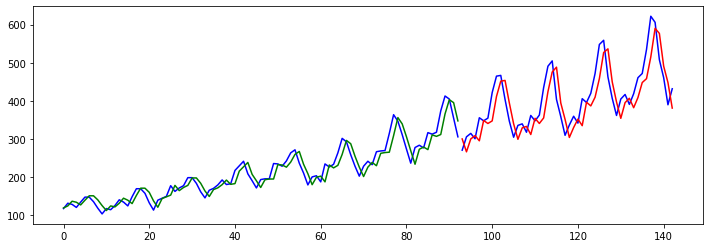

In [12]:
MSE = np.mean((y_test - pred_test)**2)
MAE = np.mean(np.abs(y_test - pred_test))
MAPE = np.mean(np.abs((y_test - pred_test) / y_test))
print('MSE: ', MSE)
print('MAE: ', MAE)
print('MAPE: ', MAPE)

plt.figure(figsize=(12, 4))
plt.plot(y_train, c='blue')
plt.plot([i + len(y_train) for i in range(len(y_test))], y_test, c='blue')

plt.plot(pred_train, c='green')
plt.plot([i + len(pred_train) for i in range(len(pred_test))],
         pred_test,
         c='red')
plt.show()

#### Preprocessed

In [13]:
df = pd.read_csv('airline-passengers.csv',
                 index_col='Month',
                 parse_dates=['Month'])
df['trend'] = df['Passengers'].ewm(halflife=12).mean()
df['detrended'] = df['Passengers'] / df['trend']
df_seasonality = df['detrended'].groupby(
    df.index.month).mean().rename('seasonality')
df = df.join(df_seasonality, how='left', on=df.index.month)
df['preprocessed'] = df['detrended'] - df['seasonality']

In [14]:
X = df['preprocessed'].values.reshape(-1, 1)
X = X.astype('float32')

In [15]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

In [16]:
N = len(X)
split = int(N * 0.65)

In [17]:
X_train, y_train = X[:split], X[1:split + 1].reshape(-1)
X_test, y_test = X[split:-1], X[split + 1:].reshape(-1)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [18]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [19]:
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=0)

In [20]:
pred_train, pred_test = model.predict(X_train), model.predict(X_test)

In [21]:
pred_train, pred_test = scaler.inverse_transform(pred_train).reshape(
    -1), scaler.inverse_transform(pred_test).reshape(-1)

In [22]:
y_train, y_test = scaler.inverse_transform(
    [y_train]).reshape(-1), scaler.inverse_transform([y_test]).reshape(-1)

MSE:  0.0014424942954020428
MAE:  0.028871182112467926
MAPE:  1.4908034006160096


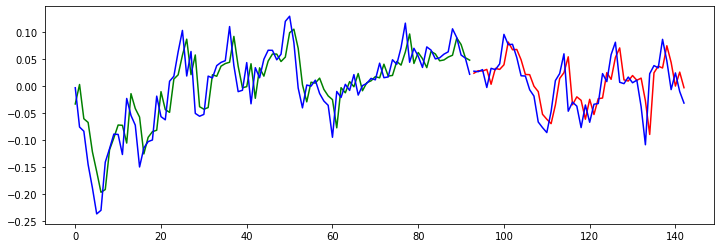

In [23]:
MSE = np.mean((y_test - pred_test)**2)
MAE = np.mean(np.abs(y_test - pred_test))
MAPE = np.mean(np.abs((y_test - pred_test) / y_test))
print('MSE: ', MSE)
print('MAE: ', MAE)
print('MAPE: ', MAPE)

plt.figure(figsize=(12, 4))
plt.plot(pred_train, c='green')
plt.plot([i + len(pred_train) for i in range(len(pred_test))],
         pred_test,
         c='red')

plt.plot(y_train, c='blue')
plt.plot([i + len(y_train) for i in range(len(y_test))], y_test, c='blue')
plt.show()

In [24]:
df['prediction_raw'] = np.hstack([[0], pred_train, pred_test])

In [25]:
df['prediction'] = (df['prediction_raw'] + df['seasonality']) * df['trend']

MSE:  205.52695307826463
MAE:  10.688316461703828
MAPE:  0.02576633539173699


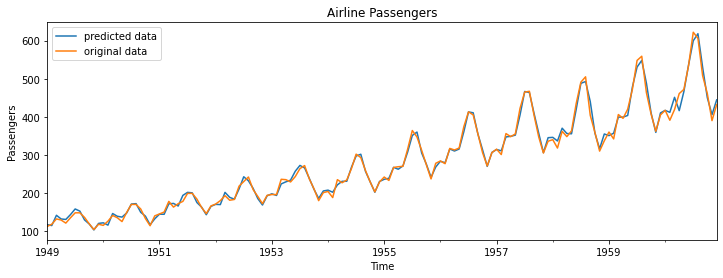

In [27]:
pred = np.array(df['prediction'])[split + 1:]
val = np.array(df['Passengers'])[split + 1:]

MSE = np.mean((val - pred)**2)
MAE = np.mean(np.abs(val - pred))
MAPE = np.mean(np.abs((val - pred) / val))
print('MSE: ', MSE)
print('MAE: ', MAE)
print('MAPE: ', MAPE)

plt.figure(figsize=(12, 4))
df['prediction'].plot(label='predicted data')
df['Passengers'].plot(label='original data')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

### GRU

In [28]:
df = pd.read_csv('airline-passengers.csv',
                 index_col='Month',
                 parse_dates=['Month'])
df['trend'] = df['Passengers'].ewm(halflife=12).mean()
df['detrended'] = df['Passengers'] / df['trend']
df_seasonality = df['detrended'].groupby(
    df.index.month).mean().rename('seasonality')
df = df.join(df_seasonality, how='left', on=df.index.month)
df['preprocessed'] = df['detrended'] - df['seasonality']

In [29]:
X = df['preprocessed'].values.reshape(-1, 1)
X = X.astype('float32')

In [30]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

In [31]:
N = len(X)
split = int(N * 0.65)

In [32]:
X_train, y_train = X[:split], X[1:split + 1].reshape(-1)
X_test, y_test = X[split:-1], X[split + 1:].reshape(-1)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [35]:
model = Sequential()
model.add(GRU(4, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [36]:
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=0)

In [37]:
pred_train, pred_test = model.predict(X_train), model.predict(X_test)

In [38]:
pred_train, pred_test = scaler.inverse_transform(pred_train).reshape(
    -1), scaler.inverse_transform(pred_test).reshape(-1)

In [39]:
y_train, y_test = scaler.inverse_transform(
    [y_train]).reshape(-1), scaler.inverse_transform([y_test]).reshape(-1)

MSE:  0.0014498643394820778
MAE:  0.028935410324782942
MAPE:  1.5134796702158102


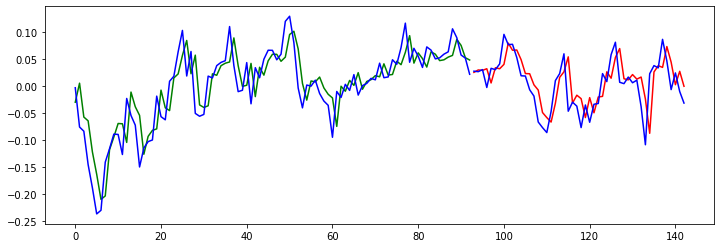

In [40]:
MSE = np.mean((y_test - pred_test)**2)
MAE = np.mean(np.abs(y_test - pred_test))
MAPE = np.mean(np.abs((y_test - pred_test) / y_test))
print('MSE: ', MSE)
print('MAE: ', MAE)
print('MAPE: ', MAPE)

plt.figure(figsize=(12, 4))
plt.plot(pred_train, c='green')
plt.plot([i + len(pred_train) for i in range(len(pred_test))],
         pred_test,
         c='red')

plt.plot(y_train, c='blue')
plt.plot([i + len(y_train) for i in range(len(y_test))], y_test, c='blue')
plt.show()

In [41]:
df['prediction_raw'] = np.hstack([[0], pred_train, pred_test])

In [42]:
df['prediction'] = (df['prediction_raw'] + df['seasonality']) * df['trend']

MSE:  206.37772095988578
MAE:  10.713580482147517
MAPE:  0.025936473642123793


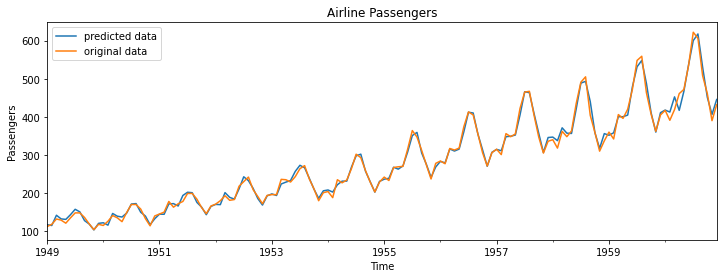

In [43]:
pred = np.array(df['prediction'])[split + 1:]
val = np.array(df['Passengers'])[split + 1:]

MSE = np.mean((val - pred)**2)
MAE = np.mean(np.abs(val - pred))
MAPE = np.mean(np.abs((val - pred) / val))
print('MSE: ', MSE)
print('MAE: ', MAE)
print('MAPE: ', MAPE)

plt.figure(figsize=(12, 4))
df['prediction'].plot(label='predicted data')
df['Passengers'].plot(label='original data')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

## Assignment 4. (5 points)
See the MovieLens datasets (https://grouplens.org/datasets/movielens/).

    a) Run the simple collaborative filtering algorithms for preparing recommendations on the MovieLens 100k dataset as well as on a few larger MovieLens datasets (depending on your computational platform). You may use either your own implementation or some implementations available in the scikit-surprise package [4].

    b) Use also the matrix factorization algorithms, such as SVD and SVD++.

    c) Propose a methodology of comparing the results of different recommendation algorithms. Why the regular cross-validation is not a best choice?

    d) Try to compare the recommendation accuracy for experienced users (with many products rated) and for less active users (with only few products rated).
    
    e) Propose a method of evaluating and comparing the coverage and the diversity of the recommendation generated. 
    
[4] N. Hug, " Surprise: A Python library for recommender systems", Journal of Open Source Software, 5(52), 2020, pp.2174. 

In [2]:
from surprise import Dataset
from surprise import SVD, SVDpp
from surprise import KNNBasic
from surprise.dataset import Dataset
from surprise.model_selection import train_test_split
from surprise import accuracy

In [41]:
def coverage_and_diversity(test_predictions, N=10):
    test_predictions_tuples = [pred[:4] for pred in test_predictions]
    test_pred_df = pd.DataFrame(test_predictions_tuples,
                                columns=['uid', 'iid', 'r_ui', 'est'])
    highest_est_per_user = []

    for uid in range(1, 944):
        highest_est_per_user.append(
            list(
                map(
                    lambda e: e[0],
                    sorted(test_pred_df.loc[test_pred_df['uid'] == str(uid)][[
                        'iid', 'est'
                    ]].values,
                           key=lambda e: e[1],
                           reverse=True)[:N])))
    unique, counts = np.unique(highest_est_per_user, return_counts=True)
    coverage = len(unique) / 1682
    X = np.zeros(1682)
    X[np.array(list(map(int, unique)))] = counts/N
    plt.figure(figsize=(15, 5))
    plt.plot(X)
    plt.show()
    return coverage

### a) 
Run the simple collaborative filtering algorithms for preparing recommendations on the MovieLens 100k dataset as well as on a few larger MovieLens datasets (depending on your computational platform). You may use either your own implementation or some implementations available in the scikit-surprise package [4].

#### ML 100k

In [3]:
ml_100k = Dataset.load_builtin(name=u'ml-100k', prompt=True)

In [5]:
trainset, testset = train_test_split(ml_100k, test_size=.35)

In [6]:
cf = KNNBasic()
cf.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [7]:
predictions = cf.test(testset)

In [8]:
MSE = accuracy.mse(predictions)
MAE = accuracy.mae(predictions)
RMSE = accuracy.rmse(predictions)

MSE: 0.9762
MAE:  0.7826
RMSE: 0.9880


In [4]:
all_trainset = ml_100k.build_full_trainset()

In [5]:
cf = KNNBasic()
cf.fit(all_trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [6]:
coverage_testset = [
    (str(i), str(j), '0.0') for i in range(1, 944) for j in range(1, 1683)
]

In [7]:
coverage_predictions = cf.test(coverage_testset)

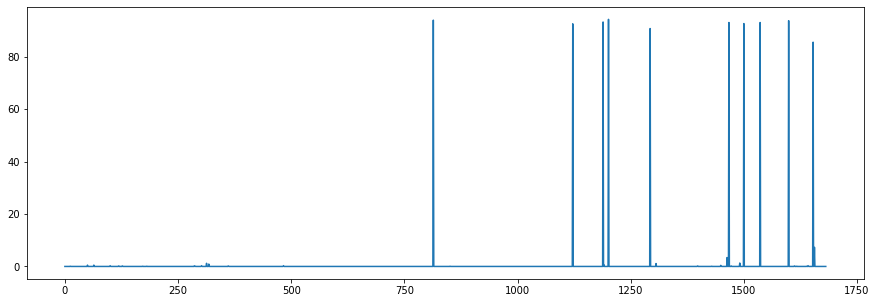

0.023781212841854936

In [42]:
coverage_and_diversity(coverage_predictions)

#### ML-1m

In [5]:
ml_1m = Dataset.load_builtin(name=u'ml-1m', prompt=True)

In [67]:
trainset, testset = train_test_split(ml_1m, test_size=.35)

In [68]:
cf = KNNBasic()
cf.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [69]:
predictions = cf.test(testset)

In [70]:
MSE = accuracy.mse(predictions)
MAE = accuracy.mae(predictions)
RMSE = accuracy.rmse(predictions)

MSE: 0.8631
MAE:  0.7339
RMSE: 0.9291


### b) 
Use also the matrix factorization algorithms, such as SVD and SVD++.

#### SVD

In [14]:
trainset, testset = train_test_split(ml_100k, test_size=.35)

In [15]:
cf = SVD()
cf.fit(trainset)

In [16]:
predictions = cf.test(testset)

In [17]:
MSE = accuracy.mse(predictions)
MAE = accuracy.mae(predictions)
RMSE = accuracy.rmse(predictions)

MSE: 0.8925
MAE:  0.7446
RMSE: 0.9447


In [43]:
all_trainset = ml_100k.build_full_trainset()

In [44]:
cf = SVD()
cf.fit(all_trainset)

In [45]:
coverage_testset = [
    (str(i), str(j), '0.0') for i in range(1, 944) for j in range(1, 1683)
]

In [46]:
coverage_predictions = cf.test(coverage_testset)

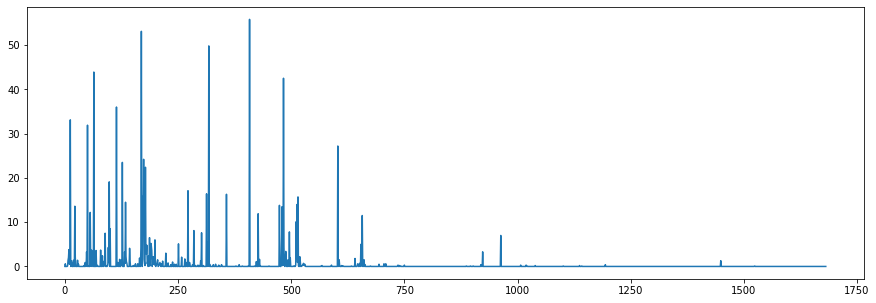

0.1516052318668252

In [47]:
coverage_and_diversity(coverage_predictions)

#### SVD++

In [23]:
cf = SVDpp()
cf.fit(trainset)

In [24]:
predictions = cf.test(testset)

In [25]:
MSE = accuracy.mse(predictions)
MAE = accuracy.mae(predictions)
RMSE = accuracy.rmse(predictions)

MSE: 0.8579
MAE:  0.7274
RMSE: 0.9262


In [48]:
all_trainset = ml_100k.build_full_trainset()

In [49]:
cf = SVDpp()
cf.fit(all_trainset)

In [50]:
coverage_testset = [
    (str(i), str(j), '0.0') for i in range(1, 944) for j in range(1, 1683)
]

In [51]:
coverage_predictions = cf.test(coverage_testset)

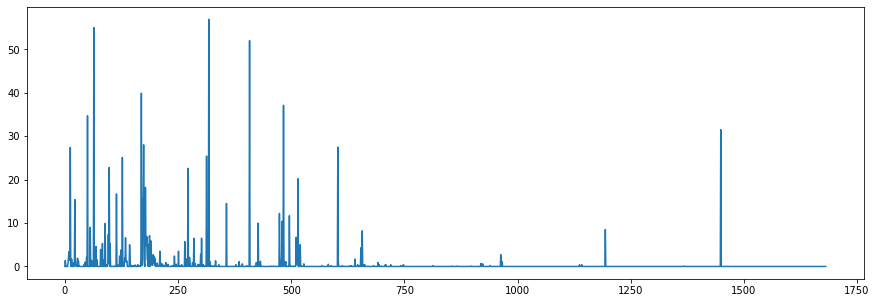

0.1426872770511296

In [52]:
coverage_and_diversity(coverage_predictions)

### c) 
Propose a methodology of comparing the results of different recommendation algorithms. Why the regular cross-validation is not a best choice?

### d) 
Try to compare the recommendation accuracy for experienced users (with many products rated) and for less active users (with only few products rated).

#### KNN

In [28]:
trainset, testset = train_test_split(ml_1m, test_size=.35)

In [29]:
cf = KNNBasic()
cf.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [30]:
full_set = ml_1m.build_full_trainset().build_testset()

In [32]:
number_of_rates = {}
for uid, iid, score in full_set:
    if uid in number_of_rates:
        number_of_rates[uid] += 1
    else:
        number_of_rates[uid] = 1

In [46]:
testset_predictions = cf.test(testset)

In [83]:
max_v = 1250
step = 25
N_buckets = int(max_v / step)
preds = [[] for _ in range(N_buckets)]
for pred in testset_predictions:
    uid = pred[0]
    number_of_rates_ = number_of_rates[uid]
    idx = min(N_buckets - 1, number_of_rates_ // step)
    preds[idx].append(pred)

In [84]:
mae_rmse = np.array(
    list(
        map(
            lambda l:
            (accuracy.mae(l, verbose=False), accuracy.rmse(l, verbose=False))
            if l else (None, None), preds)))

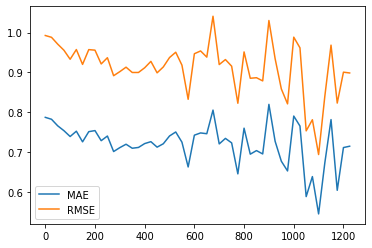

In [85]:
plt.plot(step * np.arange(N_buckets), mae_rmse[:, 0], label='MAE')
plt.plot(step * np.arange(N_buckets), mae_rmse[:, 1], label='RMSE')
plt.legend()
plt.show()

#### SVD

In [6]:
trainset, testset = train_test_split(ml_1m, test_size=.35)

In [7]:
cf = SVD()
cf.fit(trainset)

In [8]:
full_set = ml_1m.build_full_trainset().build_testset()

In [9]:
number_of_rates = {}
for uid, iid, score in full_set:
    if uid in number_of_rates:
        number_of_rates[uid] += 1
    else:
        number_of_rates[uid] = 1

In [10]:
testset_predictions = cf.test(testset)

In [11]:
max_v = 1250
step = 25
N_buckets = int(max_v / step)
preds = [[] for _ in range(N_buckets)]
for pred in testset_predictions:
    uid = pred[0]
    number_of_rates_ = number_of_rates[uid]
    idx = min(N_buckets - 1, number_of_rates_ // step)
    preds[idx].append(pred)

In [12]:
mae_rmse = np.array(
    list(
        map(
            lambda l:
            (accuracy.mae(l, verbose=False), accuracy.rmse(l, verbose=False))
            if l else (None, None), preds)))

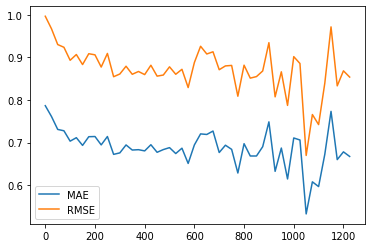

In [13]:
plt.plot(step * np.arange(N_buckets), mae_rmse[:, 0], label='MAE')
plt.plot(step * np.arange(N_buckets), mae_rmse[:, 1], label='RMSE')
plt.legend()
plt.show()

### e) 
Propose a method of evaluating and comparing the coverage and the diversity of the recommendation generated.

## Assignment 5. (optional - 5 bonus points)
The Yelp Open Dataset (https://www.yelp.com/dataset) contains data businesses, their users and ratings of businesses by their users as well as some rich meta-data concerning the users and the businesses.

    a) Try to use the regular recommendation techniques to generate recommendations of the businesses to the users and evaluate them (similarly to Assignment 4). 
    
    b) Propose a method of clustering similar businesses (based on some selected meta-data from the dataset) and generate recommendations of the business clusters to the users (e.g. recommend clusters of businesses instead of individual businesses) and evaluate them.
    
    c) For each user u, for each business cluster c, evaluate the mean rating µu, c of the businesses from the cluster c by the user u. Next, normalize the ratings ru, b of the businesses b by the user u by subtracting µu, c from ru, b (for c being the cluster containing the business b). Run the regular recommendation algorithms on the normalized ratings and compare the results with a). 

In the case of large computational requirements and long computation times, you may focus on a selected part of the entire dataset. 

### a) 
Try to use the regular recommendation techniques to generate recommendations of the businesses to the users and evaluate them (similarly to Assignment 4).

### b)
Propose a method of clustering similar businesses (based on some selected meta-data from the dataset) and generate recommendations of the business clusters to the users (e.g. recommend clusters of businesses instead of individual businesses) and evaluate them.


### c) 
For each user u, for each business cluster c, evaluate the mean rating µu, c of the businesses from the cluster c by the user u. Next, normalize the ratings ru, b of the businesses b by the user u by subtracting µu, c from ru, b (for c being the cluster containing the business b). Run the regular recommendation algorithms on the normalized ratings and compare the results with a).